In [1]:
from System import System

import numpy as np
from scipy import stats
from graphviz import Digraph
import matplotlib.pyplot as plt
from itertools import permutations
import random

In [2]:
def plot_production(sys):
    # get data after warmup
    data = sys.production_data[sys.production_data['time']>=0]
    
    plt.figure(figsize=(12,6))
    for m in range(sys.M):
        plt.plot(data['time'], 
                 data['M{} production'.format(m)], 
                 label='M{}'.format(m), lw=3)
    
    # plot ideal production line
    plt.plot([0,sys.sim_time], [0,sys.sim_time/sys.bottleneck_process_time], 
             ':', c='dimgrey', lw=2, label='Ideal production')
    
    plt.xlabel('time', fontsize=12)
    plt.ylabel('units produced', fontsize=12)
    plt.legend(fontsize=14)
    plt.show()

In [3]:
def plot_throughput(sys):
    # get data after warmup
    data = sys.production_data[sys.production_data['time']>=0]
    
    plt.figure(figsize=(12,6))
    for m in range(sys.M):
        plt.plot(data['time'], data['M{} throughput'.format(m)], label='M{}'.format(m), lw=3)
   
    # plot bottleneck rate
    plt.axhline(y=1/sys.bottleneck_process_time, linestyle=':', c='dimgrey', lw=2, label='Bottleneck rate')
    
    plt.xlabel('time', fontsize=12)
    plt.ylabel('throughput', fontsize=12)
    plt.legend(fontsize=14)
    plt.show()

### Single-machine production

In [4]:
sys1 = System(process_times=[3], degradation=[0], buffer_sizes=0)
sys1.simulate(sim_time=100)

Simulation complete in 0.57s


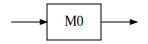

In [5]:
sys1.draw()

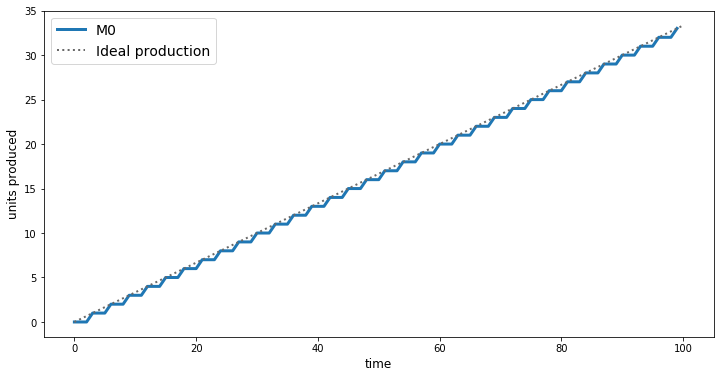

In [6]:
plot_production(sys1)

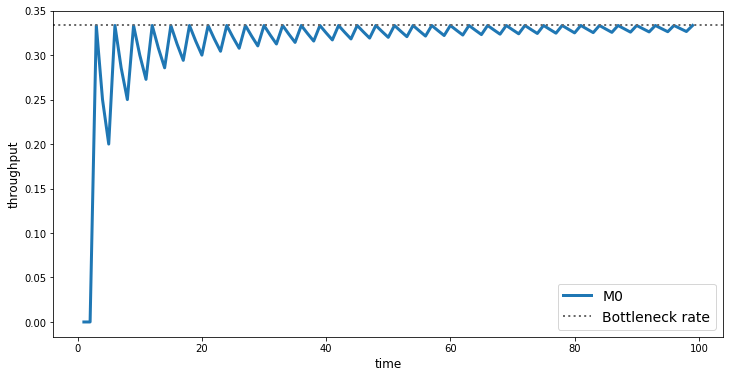

In [7]:
plot_throughput(sys1)

### Single machine with degradation and corrective maintenance

In [8]:
sys2 = System(process_times=[3], degradation=[0.25], buffer_sizes=0, 
              maintenance_policy='CM')
sys2.simulate(sim_time=100)

Simulation complete in 0.11s


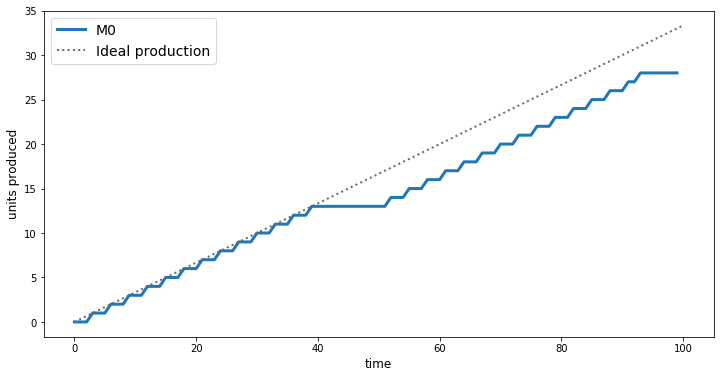

In [9]:
plot_production(sys2)

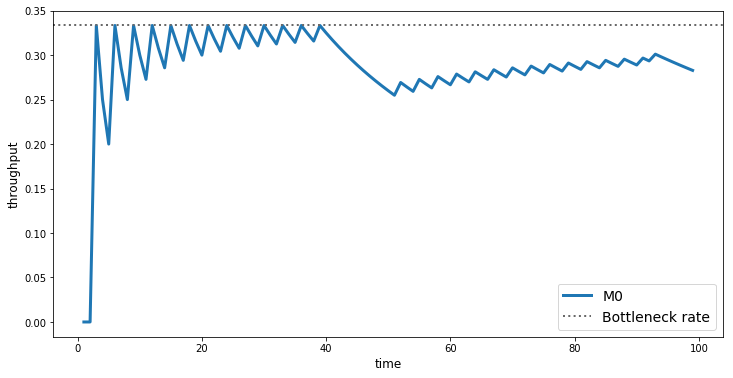

In [10]:
plot_throughput(sys2)

In [11]:
sys2.maintenance_data

,time,machine,type,activity,duration
0,39,0,CM,failure,
1,49,0,CM,repair,10
2,93,0,CM,failure,


### Five machines in series with corrective maintenance

In [12]:
sys3 = System(process_times=[2, 2, 5, 3, 1], degradation=[0.2]*5, 
              buffer_sizes=2, maintenance_policy='CM')
sys3.simulate(warmup_time=100, sim_time=100)

Simulation complete in 0.50s


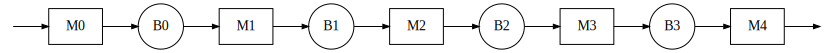

In [13]:
sys3.draw()

In [14]:
sys3.maintenance_data

,time,machine,type,activity,duration
0,-57,2,CM,failure,
1,-56,3,CM,failure,
2,-54,1,CM,failure,
3,-47,2,CM,repair,10
4,-46,3,CM,repair,10
5,-46,4,CM,failure,
6,-44,1,CM,repair,10
7,-36,4,CM,repair,10
8,-36,0,CM,failure,
9,-26,0,CM,repair,10


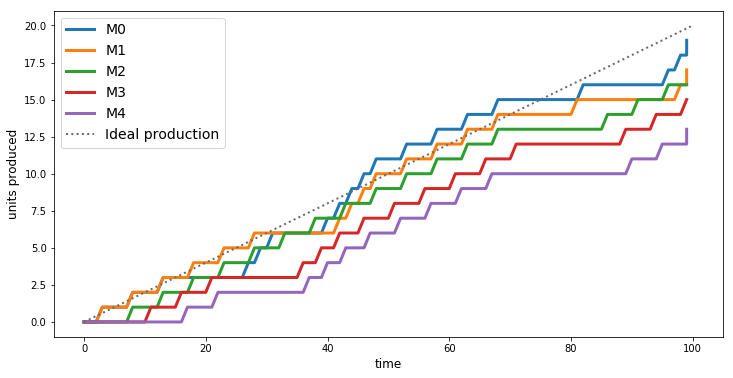

In [15]:
plot_production(sys3)

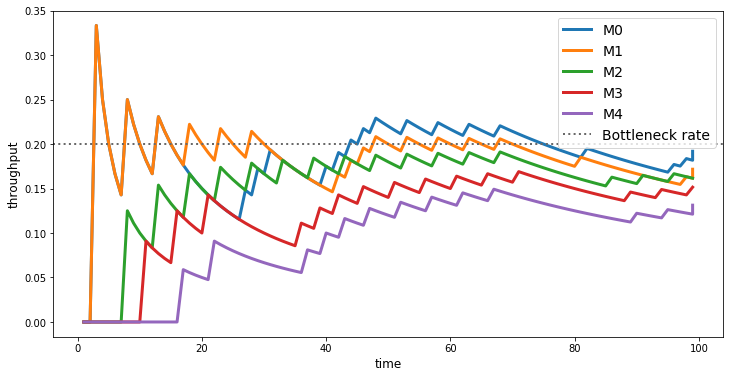

In [16]:
plot_throughput(sys3)

### Markov degradation

In [17]:
# collect n samples of time to failure
def sample_ttf(Q, n):
    states = list(range(len(Q)))
    samples = []
    for sample in range(n):
        ttf = 0
        state = 0
        while state != states[-1]:
            state = np.random.choice(states, p=Q[state])
            ttf += 1
        samples += [ttf]
    return np.array(samples)

In [18]:
Q_1 = np.array([[0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.9, 0.1, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.9, 0.1, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.9, 0.1, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.9, 0.1],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

samples = sample_ttf(Q_1, n=5000)
print('mean TTF = {}'.format(np.average(samples)))

mean TTF = 49.779


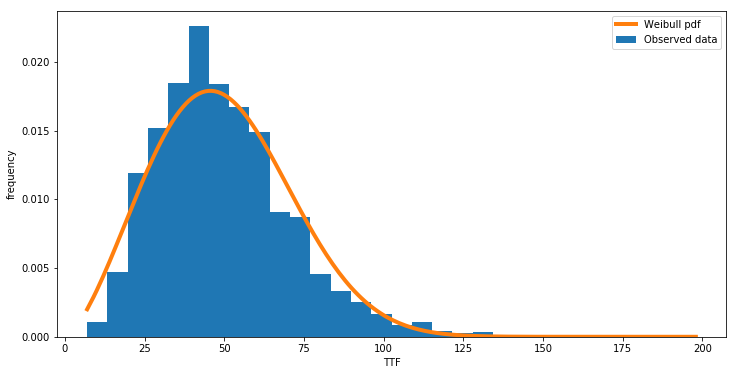

In [19]:
plt.figure(figsize=(12,6))
plt.hist(samples, bins=30, density=1, label='Observed data')
plt.plot(np.sort(samples), stats.exponweib.pdf(np.sort(samples), *stats.exponweib.fit(samples, f0=1, floc=0)), 
         lw=4, label='Weibull pdf')
plt.xlabel('TTF')
plt.ylabel('frequency')
plt.legend()
plt.show()

### Three machines with planned failure

#### No impact on bottleneck

In [20]:
sys4 = System(process_times=[2, 5, 3], degradation=[0]*5, buffer_sizes=2,
              planned_failures=[(0,20,15)])
sys4.simulate(sim_time=100)

Simulation complete in 0.27s


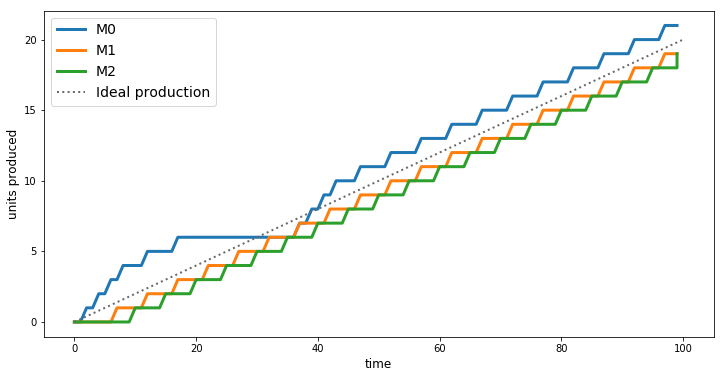

In [21]:
plot_production(sys4)

#### Impact on bottleneck

In [22]:
sys5 = System(process_times=[2, 5, 3], degradation=[0]*5, buffer_sizes=2,
              planned_failures=[(0,20,30)])
sys5.simulate(warmup_time=50, sim_time=100)

Simulation complete in 0.23s


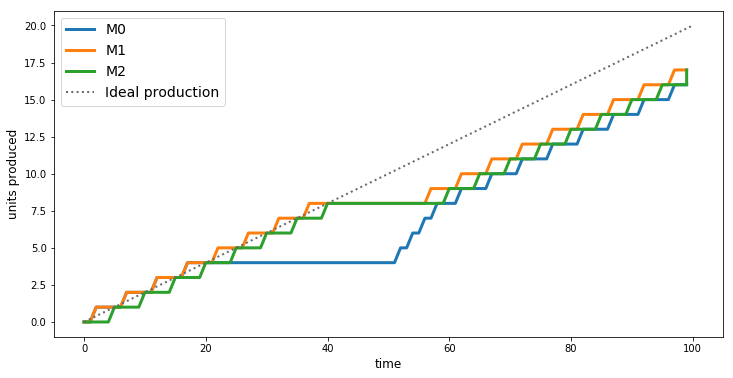

In [23]:
plot_production(sys5)

### Scheduling multiple downtime events

In [24]:
'''
M0: (0, ?, 150)
M1: (1, ?, 15)
M2: (2, ?, 300)
'''

DT = {0: 50,
      1: 5,
      2: 30}

service_order1 = [0, 1, 2]
service_order2 = [2, 1, 0]

#### Service order [0, 1, 2]

In [25]:
# 0, 1, 2
M1, M2, M3 = service_order1

# start times
T1 = 10
T2 = T1 + DT[M1]
T3 = T2 + DT[M2]

F = [(M1, T1, DT[M1]),
     (M2, T2, DT[M2]),
     (M3, T3, DT[M3])]

sys6 = System(process_times=[3, 5, 2], buffer_sizes=4, planned_failures=F)
sys6.simulate(warmup_time=100, sim_time=200)

Simulation complete in 0.37s


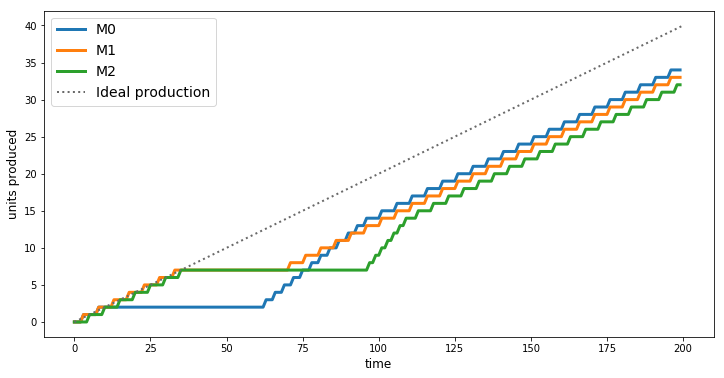

Ideal production: 40 units
Acutal production: 32 units


In [26]:
plot_production(sys6)
print('Ideal production: {} units'.format(int(sys6.sim_time/sys6.bottleneck_process_time)))
print('Acutal production: {} units'.format(sys6.machines[-1].parts_made))

#### Service order [2, 1, 0]

In [27]:
# 0, 1, 2
M1, M2, M3 = service_order2

# start times
T1 = 10
T2 = T1 + DT[M1]
T3 = T2 + DT[M2]

F = [(M1, T1, DT[M1]),
     (M2, T2, DT[M2]),
     (M3, T3, DT[M3])]

sys7 = System(process_times=[3, 5, 2], buffer_sizes=4, planned_failures=F)
sys7.simulate(warmup_time=100, sim_time=200)

Simulation complete in 0.40s


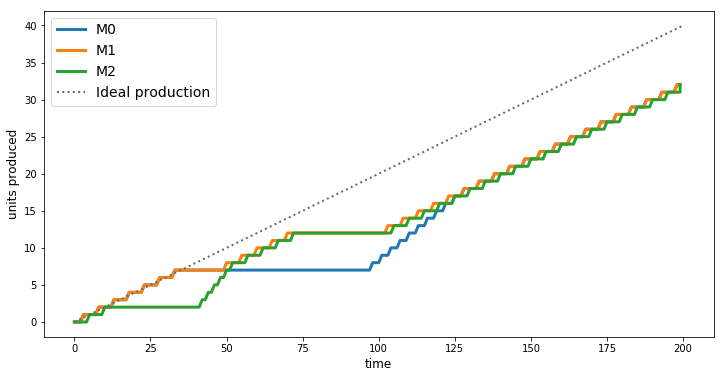

Ideal production: 40 units
Acutal production: 32 units


In [28]:
plot_production(sys7)
print('Ideal production: {} units'.format(int(sys7.sim_time/sys7.bottleneck_process_time)))
print('Acutal production: {} units'.format(sys7.machines[-1].parts_made))

#### All service order permutations

In [29]:
DT = {0: 50,
      1: 25,
      2: 3}

print('Ideal production: {} units\n'.format(int(200/5)))

for service_order in permutations([0, 1, 2]):
    M1, M2, M3 = service_order
    
    T1 = 10
    T2 = T1 + DT[M1]
    T3 = T2 + DT[M2]
    
    F = [(M1, T1, DT[M1]),
         (M2, T2, DT[M2]),
         (M3, T3, DT[M3])]
    
    sys = System(process_times=[3, 5, 2], buffer_sizes=1, planned_failures=F)
    sys.simulate(warmup_time=100, sim_time=200, verbose=False)
    
    print('Service order:         {}'.format(str(service_order)))
    print('Units produced:        {}'.format(sys.machines[-1].parts_made))
    print('Units lost production: {}'.format(int(200/5 - sys.machines[-1].parts_made)))
    print()

Ideal production: 40 units

Service order:         (0, 1, 2)
Units produced:        25
Units lost production: 15

Service order:         (0, 2, 1)
Units produced:        25
Units lost production: 15

Service order:         (1, 0, 2)
Units produced:        25
Units lost production: 15

Service order:         (1, 2, 0)
Units produced:        25
Units lost production: 15

Service order:         (2, 0, 1)
Units produced:        26
Units lost production: 14

Service order:         (2, 1, 0)
Units produced:        25
Units lost production: 15

